In [170]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

# We first work on a 2D dataset with size 28x28

In [171]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [172]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])

])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\creep\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\creep\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\creep\.medmnist\pneumoniamnist.npz


In [173]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 64 (pneumoniamnist_64)
    Number of datapoints: 4708
    Root location: C:\Users\creep\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 64 (pneumoniamnist_64)
    Number of datapoints: 624
    Root location: C:\Users\creep\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {

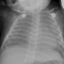

In [174]:
# visualization

train_dataset.montage(length=1)

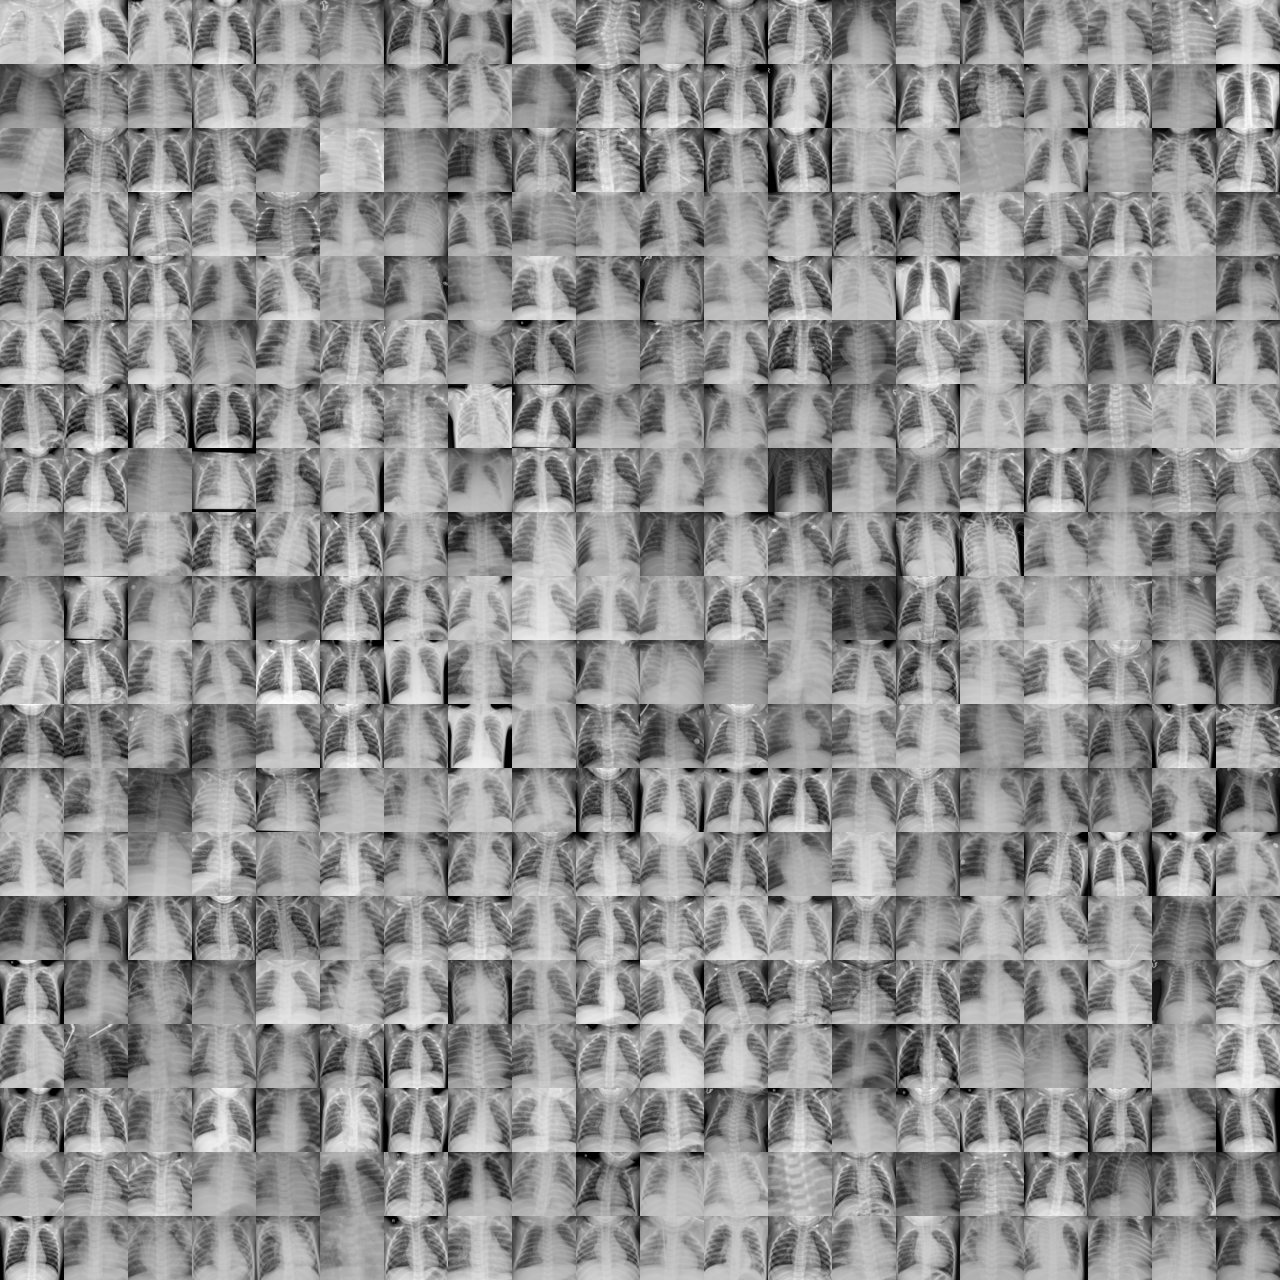

In [175]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [184]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 13*13, 128),  # Adjusted for 64x64 input size
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [185]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:14<00:00,  2.60it/s]


In [186]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 1.000  acc:0.999
test  auc: 0.952  acc:0.808


# We then check a 2D dataset with size 224x224

In [187]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    
])
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64, mmap_mode='r')

test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64, mmap_mode='r')



# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

x, y = train_dataset[0]

print(x.shape, y.shape)

Using downloaded and verified file: C:\Users\creep\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\creep\.medmnist\pneumoniamnist_64.npz
torch.Size([3, 64, 64]) (1,)


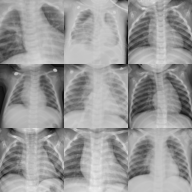

In [188]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [189]:

from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).cuda()

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [190]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:02<00:00, 13.65it/s]


In [192]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

test  auc: 0.947  acc: 0.838
